<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TED-Talks" data-toc-modified-id="TED-Talks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TED Talks</a></span></li><li><span><a href="#Токенизация" data-toc-modified-id="Токенизация-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Токенизация</a></span></li><li><span><a href="#Распределение-слов-по-частоте,-стоп-слова" data-toc-modified-id="Распределение-слов-по-частоте,-стоп-слова-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Распределение слов по частоте, стоп слова</a></span></li><li><span><a href="#Приведение-к-нормальной-форме" data-toc-modified-id="Приведение-к-нормальной-форме-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Приведение к нормальной форме</a></span></li><li><span><a href="#Выделение-коллокаций" data-toc-modified-id="Выделение-коллокаций-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выделение коллокаций</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>TF-IDF</a></span><ul class="toc-item"><li><span><a href="#поиск-похожих" data-toc-modified-id="поиск-похожих-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>поиск похожих</a></span></li><li><span><a href="#выделение-ключевых-слов" data-toc-modified-id="выделение-ключевых-слов-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>выделение ключевых слов</a></span></li></ul></li><li><span><a href="#Word2Vec" data-toc-modified-id="Word2Vec-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Word2Vec</a></span><ul class="toc-item"><li><span><a href="#Sentence-Embeddings" data-toc-modified-id="Sentence-Embeddings-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Sentence Embeddings</a></span></li></ul></li><li><span><a href="#Topic-Modeling" data-toc-modified-id="Topic-Modeling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Topic Modeling</a></span><ul class="toc-item"><li><span><a href="#Поиск-похожих-документов" data-toc-modified-id="Поиск-похожих-документов-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Поиск похожих документов</a></span></li><li><span><a href="#Краткое-описание-документов-(суммаризация)" data-toc-modified-id="Краткое-описание-документов-(суммаризация)-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Краткое описание документов (суммаризация)</a></span></li><li><span><a href="#Визуализация-тематической-модели" data-toc-modified-id="Визуализация-тематической-модели-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Визуализация тематической модели</a></span></li></ul></li></ul></div>

Uncomment if you are using colab

In [1]:
#!pip install razdel==0.5
#!pip install pyLDAvis==2.1.2
#!pip install pymorphy2==0.8

     |████████████████████████████████| 1.6 MB 1.7 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=0f238450ff43ee8a58b570a0ff4e0b611d6d7c587c89d52e807d7dd787783dc3
  Stored in directory: /Users/k.shematorov/Library/Caches/pip/wheels/31/8c/a0/24a443892f2134e691d59c8c6c35e19821e02f85e49871f8fd
Successfully built pyLDAvis
     |████████████████████████████████| 46 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 7.1 MB 2.4 MB/s eta 0:00:01
  Attempting uninstall: pymorphy2
    Found existing installation: pymorphy2 0.9.1
    Uninstalling pymorphy2-0.9.1:
      Successfully uninstalled pymorphy2-0.9.1


In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
from collections import Counter

import razdel
import nltk
nltk.download('stopwords')
import pymorphy2
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly
from tqdm import tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import pyLDAvis
import pyLDAvis.gensim

from IPython.display import YouTubeVideo

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/k.shematorov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/k.shematorov/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
SEED = 42
np.random.seed(SEED)

TOKEN_PATTERN = "[а-яё]+"

DATA_PATH = 'ted_talks.csv'

Uncomment if you are using colab

In [3]:
#!mkdir ./data
#!wget https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/master/lecture06/data/ted_talks.csv.gz -O $DATA_PATH

# TED Talks

In [4]:
df = pd.read_csv(DATA_PATH)

df.head()

,talk,text
0,jonas_gahr_store_in_defense_of_dialogue,"Среди всех дефицитов , беспокоящих нас сегодня..."
1,iwan_baan_ingenious_homes_in_unexpected_places,Мне крупно везло на протяжении всей моей карье...
2,melinda_french_gates_what_nonprofits_can_learn...,Больше всего я люблю в моей работе в Фонде Гей...
3,dean_kamen_on_inventing_and_giving,"Как уже было замечено , каждый раз , приходя с..."
4,bruno_maisonnier_dance_tiny_robots,( Механические шумы ) ( Музыка ) ( Аплодисменты )


In [5]:
df.shape

(2093, 2)

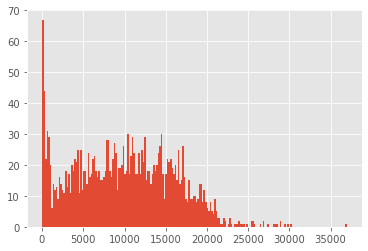

In [6]:
df.text.str.len().hist(bins=200);

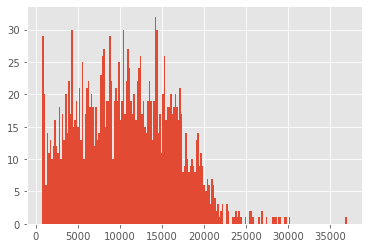

In [7]:
min_talk_len = 750

df = df[df.text.str.len() >= min_talk_len].reset_index(drop=True)

df.text.str.len().hist(bins=200);

In [8]:
df.shape

(1929, 2)

In [9]:
corpus = df.text.values

# Токенизация

In [10]:
sentence = "Как же так?! Олег... Мы же в 18.00 договаривались встретиться:("

print(sentence.split())

['Как', 'же', 'так?!', 'Олег...', 'Мы', 'же', 'в', '18.00', 'договаривались', 'встретиться:(']


In [11]:
print(re.findall("[а-яА-ЯёЁ]+", sentence))

['Как', 'же', 'так', 'Олег', 'Мы', 'же', 'в', 'договаривались', 'встретиться']


In [12]:
print(re.split(r"[-\s.,;!?]+", sentence))

['Как', 'же', 'так', 'Олег', 'Мы', 'же', 'в', '18', '00', 'договаривались', 'встретиться:(']


In [13]:
print([token.text for token in razdel.tokenize(sentence)])

['Как', 'же', 'так', '?!', 'Олег', '...', 'Мы', 'же', 'в', '18.00', 'договаривались', 'встретиться', ':(']


In [14]:
print(nltk.tokenize.casual_tokenize(sentence))

['Как', 'же', 'так', '?', '!', 'Олег', '...', 'Мы', 'же', 'в', '18.00', 'договаривались', 'встретиться', ':(']


In [15]:
corpus[0]

'Среди всех дефицитов , беспокоящих нас сегодня — прежде всего финансового и экономического — меня больше всего волнует дефицит политического диалога : нашей способности реагировать на современные конфликты в их настоящем виде , осознавать , что лежит в их основе , кто является ключевыми игроками , и как с ними работать . Мы , дипломаты , обучены работать с конфликтами и спорами между государствами . И , поверьте , работы нам хватает . Торговля , разоружение , международные отношения . Но картина меняется , и мы видим , что на сцену выходят новые ключевые игроки . Мы пренебрежительно называем их « группы » . Они представляют социальные , религиозные , политические , экономические и военные реалии . И мы изо всех сил стараемся понять , как с ними работать . Правила вступления в переговоры : как говорить , когда говорить , как найти общий язык . Позвольте показать вам график , который отражает характер конфликтов с 1946 года по сегодняшний день . Зелёный цвет — традиционные межгосударств

In [18]:
def tokenize(text):
    return re.findall(TOKEN_PATTERN, text.lower())

docs = [tokenize(text) for text in corpus]

In [19]:
docs[0]

['среди',
 'всех',
 'дефицитов',
 'беспокоящих',
 'нас',
 'сегодня',
 'прежде',
 'всего',
 'финансового',
 'и',
 'экономического',
 'меня',
 'больше',
 'всего',
 'волнует',
 'дефицит',
 'политического',
 'диалога',
 'нашей',
 'способности',
 'реагировать',
 'на',
 'современные',
 'конфликты',
 'в',
 'их',
 'настоящем',
 'виде',
 'осознавать',
 'что',
 'лежит',
 'в',
 'их',
 'основе',
 'кто',
 'является',
 'ключевыми',
 'игроками',
 'и',
 'как',
 'с',
 'ними',
 'работать',
 'мы',
 'дипломаты',
 'обучены',
 'работать',
 'с',
 'конфликтами',
 'и',
 'спорами',
 'между',
 'государствами',
 'и',
 'поверьте',
 'работы',
 'нам',
 'хватает',
 'торговля',
 'разоружение',
 'международные',
 'отношения',
 'но',
 'картина',
 'меняется',
 'и',
 'мы',
 'видим',
 'что',
 'на',
 'сцену',
 'выходят',
 'новые',
 'ключевые',
 'игроки',
 'мы',
 'пренебрежительно',
 'называем',
 'их',
 'группы',
 'они',
 'представляют',
 'социальные',
 'религиозные',
 'политические',
 'экономические',
 'и',
 'военные',
 'ре

# Распределение слов по частоте, стоп слова

Постройте словарь `слово` -> `количество вхождений в корпус`

In [20]:
occurence = Counter([token for doc in docs for token in doc])

In [21]:
len(occurence)

152238

в словаре больше 150 тыс. слов, хотя в литературном русском около 150 тыс.

In [22]:
occurence.most_common(20)

[('и', 99066),
 ('в', 88906),
 ('что', 60461),
 ('я', 49177),
 ('это', 48070),
 ('на', 41620),
 ('не', 41373),
 ('мы', 39265),
 ('с', 27817),
 ('как', 25721),
 ('но', 20070),
 ('то', 19166),
 ('вы', 18144),
 ('они', 17174),
 ('из', 16846),
 ('для', 14977),
 ('а', 14539),
 ('так', 14122),
 ('у', 13393),
 ('к', 13322)]

Самые частые слова относятся к служебным частям речи и несут мало полезной информации. Их можно отбрасывать с помощью подготовленных списков

In [23]:
stopword_set = set(nltk.corpus.stopwords.words('russian'))
# stopword_set = stopword_set.union({'это', 'который', 'весь', 'наш', 'свой', 'ещё', 'её', 'ваш', 'также', 'итак'})

In [24]:
stopword_set

{'а',
 'без',
 'более',
 'больше',
 'будет',
 'будто',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вас',
 'вдруг',
 'ведь',
 'во',
 'вот',
 'впрочем',
 'все',
 'всегда',
 'всего',
 'всех',
 'всю',
 'вы',
 'где',
 'да',
 'даже',
 'два',
 'для',
 'до',
 'другой',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'ж',
 'же',
 'за',
 'зачем',
 'здесь',
 'и',
 'из',
 'или',
 'им',
 'иногда',
 'их',
 'к',
 'как',
 'какая',
 'какой',
 'когда',
 'конечно',
 'кто',
 'куда',
 'ли',
 'лучше',
 'между',
 'меня',
 'мне',
 'много',
 'может',
 'можно',
 'мой',
 'моя',
 'мы',
 'на',
 'над',
 'надо',
 'наконец',
 'нас',
 'не',
 'него',
 'нее',
 'ней',
 'нельзя',
 'нет',
 'ни',
 'нибудь',
 'никогда',
 'ним',
 'них',
 'ничего',
 'но',
 'ну',
 'о',
 'об',
 'один',
 'он',
 'она',
 'они',
 'опять',
 'от',
 'перед',
 'по',
 'под',
 'после',
 'потом',
 'потому',
 'почти',
 'при',
 'про',
 'раз',
 'разве',
 'с',
 'сам',
 'свою',
 'себе',
 'себя',
 'сейчас',
 'со',
 'совсем',
 'так

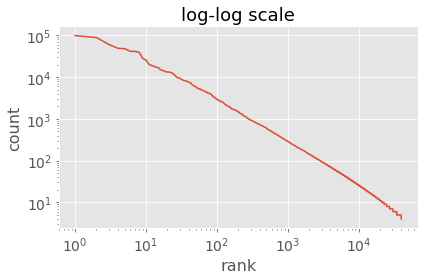

In [25]:
max_rank = 40_000

counts = [count for _, count in occurence.most_common()[:max_rank]]

plt.plot(range(1, len(counts) + 1), counts)
plt.title('log-log scale', fontsize=18)
plt.yscale('log')
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('rank', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.tight_layout()
plt.show()

# Приведение к нормальной форме

In [26]:
sorted_tokens = sorted(occurence.keys())

In [27]:
sorted_tokens

['а',
 'аа',
 'ааа',
 'аааа',
 'ааааа',
 'ааааааааа',
 'аааааааах',
 'аааав',
 'ааарон',
 'аази',
 'аакаш',
 'аарон',
 'аарона',
 'аароном',
 'аарону',
 'аб',
 'аба',
 'абаей',
 'абажур',
 'абажура',
 'абажуром',
 'абайа',
 'абайю',
 'абалон',
 'абалона',
 'абани',
 'абача',
 'аббас',
 'аббатства',
 'аббатство',
 'абби',
 'аббревиатур',
 'аббревиатура',
 'аббревиатуре',
 'аббревиатурой',
 'аббревиатуру',
 'аббревиатуры',
 'абдалла',
 'абдаллы',
 'абделлахи',
 'абдель',
 'абдельрахмана',
 'абди',
 'абдубакар',
 'абдул',
 'абдула',
 'абдуразак',
 'абдуразака',
 'абдуррахман',
 'абеба',
 'абебе',
 'абебы',
 'абед',
 'абеда',
 'абеде',
 'абедом',
 'абеду',
 'абелом',
 'абенд',
 'абердин',
 'абердине',
 'абернати',
 'абзац',
 'абзаца',
 'абзацах',
 'абзаце',
 'абзацев',
 'абзацы',
 'абзуг',
 'абигейл',
 'абиджан',
 'абиджана',
 'абидин',
 'абиссинского',
 'абитуриентам',
 'абитуриентами',
 'абитуриентов',
 'аблеизма',
 'абляцию',
 'аболиционистов',
 'аболиционисты',
 'абололо',
 'абонемент'

в словаре встречаются разные формы одного и того же слова:
* 'аббревиатур',
* 'аббревиатура',
* 'аббревиатуре',
* 'аббревиатурой',
* 'аббревиатуру',
* 'аббревиатуры'

In [28]:
stemmer = nltk.stem.SnowballStemmer('russian')

In [29]:
words = [
    'аббревиатур',
    'аббревиатура',
    'аббревиатуре',
    'аббревиатурой',
    'аббревиатуру',
    'аббревиатуры',
    'человек',
    'люди',
    'людьми'
]

In [30]:
[stemmer.stem(word) for word in words]

['аббревиатур',
 'аббревиатур',
 'аббревиатур',
 'аббревиатур',
 'аббревиатур',
 'аббревиатур',
 'человек',
 'люд',
 'людьм']

In [31]:
lemmatizer = pymorphy2.MorphAnalyzer()

In [32]:
lemmatizer.parse('стекло')[0].normal_form

'стекло'

In [33]:
[lemmatizer.parse(word)[0].normal_form for word in words]

['аббревиатура',
 'аббревиатура',
 'аббревиатура',
 'аббревиатура',
 'аббревиатура',
 'аббревиатура',
 'человек',
 'человек',
 'человек']

In [34]:
lemmatizer.word_is_known('хендай')

False

In [35]:
lemmatizer.parse('хендай')

[Parse(word='хендай', tag=OpencorporaTag('VERB,perf,tran sing,impr,excl'), normal_form='хендать', score=0.2548476454293629, methods_stack=((<DictionaryAnalyzer>, 'дай', 843, 13), (<UnknownPrefixAnalyzer>, 'хен'))),
 Parse(word='хендай', tag=OpencorporaTag('NOUN,anim,femn,Name plur,gent'), normal_form='хендая', score=0.2548476454293629, methods_stack=((<DictionaryAnalyzer>, 'дай', 169, 7), (<UnknownPrefixAnalyzer>, 'хен'))),
 Parse(word='хендай', tag=OpencorporaTag('NOUN,anim,femn,Name plur,accs'), normal_form='хендая', score=0.2548476454293629, methods_stack=((<DictionaryAnalyzer>, 'дай', 169, 9), (<UnknownPrefixAnalyzer>, 'хен'))),
 Parse(word='хендай', tag=OpencorporaTag('VERB,impf,tran sing,impr,excl'), normal_form='хендать', score=0.21883656509695293, methods_stack=((<FakeDictionary>, 'хендай', 206, 11), (<KnownSuffixAnalyzer>, 'дай'))),
 Parse(word='хендай', tag=OpencorporaTag('NOUN,inan,masc,Sgtm,Geox sing,nomn'), normal_form='хендай', score=0.008310249307479225, methods_stack=((

In [36]:
lemmatizer_cache = {}

def lemmatize(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

lemmatized_docs = [[lemmatize(token) for token in text] for text in tqdm_notebook(docs)]

cleared_docs = [[token for token in text if token not in stopword_set] for text in lemmatized_docs]

/var/folders/4r/96czjbws0jxg861vmb2f4y2r0000gp/T/ipykernel_69867/729433580.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  lemmatized_docs = [[lemmatize(token) for token in text] for text in tqdm_notebook(docs)]


  0%|          | 0/1929 [00:00<?, ?it/s]

In [37]:
cleared_docs[0]

['среди',
 'весь',
 'дефицит',
 'беспокоить',
 'сегодня',
 'прежде',
 'финансовый',
 'экономический',
 'большой',
 'волновать',
 'дефицит',
 'политический',
 'диалог',
 'наш',
 'способность',
 'реагировать',
 'современный',
 'конфликт',
 'настоящий',
 'вид',
 'осознавать',
 'лежать',
 'основа',
 'являться',
 'ключевой',
 'игрок',
 'работать',
 'дипломат',
 'обучить',
 'работать',
 'конфликт',
 'спор',
 'государство',
 'поверьте',
 'работа',
 'хватать',
 'торговля',
 'разоружение',
 'международный',
 'отношение',
 'картина',
 'меняться',
 'видеть',
 'сцена',
 'выходить',
 'новое',
 'ключевой',
 'игрок',
 'пренебрежительно',
 'называть',
 'группа',
 'представлять',
 'социальный',
 'религиозный',
 'политический',
 'экономический',
 'военный',
 'реалия',
 'весь',
 'сила',
 'стараться',
 'понять',
 'работать',
 'правило',
 'вступление',
 'переговоры',
 'говорить',
 'говорить',
 'найти',
 'общий',
 'язык',
 'позволить',
 'показать',
 'график',
 'который',
 'отражать',
 'характер',
 'конфликт

Во сколько раз уменьшился словарь после лемматизации?

In [38]:
len({token for text in cleared_docs for token in text})

53823

# Выделение коллокаций

Посчитайте, сколько раз пары слов встречались вместе

In [39]:
cooccurence = Counter([(doc[i], doc[i + 1]) for doc in docs for i in range(len(doc) - 1)])

In [40]:
cooccurence.most_common(20)

[(('потому', 'что'), 6117),
 (('то', 'что'), 4588),
 (('и', 'я'), 3929),
 (('что', 'мы'), 3727),
 (('том', 'что'), 3203),
 (('у', 'нас'), 3117),
 (('что', 'я'), 3065),
 (('что', 'это'), 3014),
 (('я', 'не'), 2867),
 (('и', 'это'), 2840),
 (('в', 'том'), 2826),
 (('что', 'то'), 2608),
 (('это', 'не'), 2507),
 (('так', 'что'), 2496),
 (('о', 'том'), 2455),
 (('и', 'в'), 2448),
 (('мы', 'можем'), 2373),
 (('самом', 'деле'), 2358),
 (('на', 'самом'), 2303),
 (('в', 'этом'), 2217)]

$$
PMI(x,y) = \log\frac{p\left(x,y\right)}{p\left(x\right)p\left(y\right)}
$$

$$
p(w_i) \sim \frac{\text{count}\left(w_i\right)}{\displaystyle\sum_{j=1}^n \text{count}\left( w_j \right)} = \frac{\text{count}\left(w_i\right)}{N}
$$

$$
PMI(w_1, w_2) \sim \log\left(\frac{N \cdot \text{count}\left(w_1, w_2\right)}{\text{count}\left(w_1\right) \text{count}\left(w_2\right) }\right)
$$

постройте словарь, в котором парам слов соответствует значения pmi

добавляйте в словарь только те пары слов, которые встретились в корпусе хотя бы `min_cooccur` раз

In [41]:
cooccurence.most_common(10)

[(('потому', 'что'), 6117),
 (('то', 'что'), 4588),
 (('и', 'я'), 3929),
 (('что', 'мы'), 3727),
 (('том', 'что'), 3203),
 (('у', 'нас'), 3117),
 (('что', 'я'), 3065),
 (('что', 'это'), 3014),
 (('я', 'не'), 2867),
 (('и', 'это'), 2840)]

In [46]:
occurence.most_common(10)

[('и', 99066),
 ('в', 88906),
 ('что', 60461),
 ('я', 49177),
 ('это', 48070),
 ('на', 41620),
 ('не', 41373),
 ('мы', 39265),
 ('с', 27817),
 ('как', 25721)]

если хочется автоматически выделять коллокации для извлечения признаков: [gensim.models.phrases.{Phrases, Phraser}](https://www.machinelearningplus.com/nlp/gensim-tutorial/#10howtocreatebigramsandtrigramsusingphrasermodels)

```python
phrases = (bows, min_count=30, progress_per=500)

bigram = gensim.models.phrases.Phraser(phrases)

bigram[bows[0]]
```

# TF-IDF

## поиск похожих

In [50]:
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x, lowercase=False, max_df=0.8, min_df=2, norm='l2'
).fit(cleared_docs)

получите tf-idf векторы документов, посчитайте cosine similarity каждого документа с каждым

In [51]:
docs_tf_idf = vectorizer.transform(cleared_docs).toarray()

In [52]:
similarities = docs_tf_idf @ docs_tf_idf.T

In [53]:
def similar_pairs_from_matrix(similarity_matrix, threshold):
    return [
        ((i, j), similarities[i, j])
        for i in range(similarities.shape[0]) for j in range(similarities.shape[1]) 
        if j > i  and similarities[i, j] > threshold
    ]


similar_pairs = similar_pairs_from_matrix(similarities, threshold=0.7) 

In [54]:
similar_pairs

[((74, 94), 0.7198235432651618),
 ((94, 1905), 0.7201352933902303),
 ((200, 1482), 0.7198712934050391),
 ((331, 1041), 0.7162091829288486),
 ((815, 1199), 0.8249961842436336),
 ((839, 965), 0.7101184016240372),
 ((884, 965), 0.7020554333381621),
 ((965, 1914), 0.7370566615803934),
 ((1393, 1536), 0.7072735015040478)]

In [55]:
similar_pairs = sorted(similar_pairs, key=lambda x: -x[1])

In [56]:
def print_talks(talk_ids, text_chunk=1024):

    for talk_id in talk_ids:
        record = df.loc[talk_id]

        print(record.talk)
        print('-' * 100)
        print(record.text[:text_chunk])
        print('#' * 100)

In [57]:
for pair, score in similar_pairs:
    print("*" * 10)
    print(f"{score:.2f}")
    print("*" * 10)
    print_talks(pair)

**********
0.82
**********
deborah_gordon_what_ants_teach_us_about_the_brain_cancer_and_the_internet
----------------------------------------------------------------------------------------------------
Я изучаю муравьёв в пустыне , в тропическом лесу , в моей кухне и на холмах вокруг Силиконовой долины , где я живу . Недавно я поняла , что муравьи взаимодействуют по-разному в разных условиях , и это натолкнуло меня на мысль , что с их помощью мы можем изучать другие системы , такие как мозг и сети передачи данных , которые мы создаём , и даже рак . Все эти системы объединяет отсутствие центра управления . Колония муравьёв состоит из стерильных самок-рабочих , муравьёв , которых мы видим вокруг , и одной или более способной к размножению матки , которая только откладывает яйца . Они не дают никаких распоряжений . Несмотря на то , что их называют королевами , они не сообщают никому , что делать . Муравьиная колония , где нет управляющих , и подобные ей системы без центра управления регул

## выделение ключевых слов

In [58]:
top_k = 10

In [59]:
doc_ids = [pair[0] for pair, threshold in similar_pairs]

In [60]:
features = np.array(vectorizer.get_feature_names())

In [61]:
[
    features[docs_tf_idf[doc_id].argsort()[::-1][:top_k]]
    for doc_id in doc_ids
]

[array(['муравей', 'колония', 'взаимодействие', 'поиск', 'сборщик', 'пища',
        'алгоритм', 'муравейник', 'ресурс', 'муравьиный'], dtype='<U23'),
 array(['робот', 'кисмет', 'игрушка', 'смех', 'внимание', 'смотреть',
        'голос', 'итак', 'исключительность', 'общение'], dtype='<U23'),
 array(['пчела', 'опыление', 'цветок', 'томат', 'пыльца', 'растение',
        'улей', 'медоносный', 'пестицид', 'пчеловод'], dtype='<U23'),
 array(['сознание', 'фундаментальный', 'закон', 'интегрирование',
        'безумный', 'наука', 'теория', 'идея', 'поведение', 'субъективный'],
       dtype='<U23'),
 array(['пчела', 'клещ', 'пчелиный', 'ячейка', 'опылитель',
        'исследователь', 'дикий', 'личинка', 'разводить', 'мёд'],
       dtype='<U23'),
 array(['клетка', 'орган', 'подложка', 'пациент', 'печень', 'мочевой',
        'стволовой', 'регенерировать', 'сосуд', 'биоматериал'],
       dtype='<U23'),
 array(['робот', 'растение', 'сад', 'рой', 'инерция', 'столкновение',
        'карта', 'сосед', 'п

# Word2Vec

In [62]:
def prepare_sentence_dataset(documents):
    tokenized_sentences = []
    for document in tqdm_notebook(documents):
        for sentence in razdel.sentenize(document):
            lemmatized_tokens = [lemmatize(token) for token in tokenize(sentence.text)]
            tokenized_sentences.append(
                [token for token in lemmatized_tokens if token not in stopword_set]
            )
    return tokenized_sentences

sentence_dataset = prepare_sentence_dataset(corpus)

/var/folders/4r/96czjbws0jxg861vmb2f4y2r0000gp/T/ipykernel_69867/41998792.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for document in tqdm_notebook(documents):


  0%|          | 0/1929 [00:00<?, ?it/s]

In [63]:
len(sentence_dataset)

258372

In [64]:
sentence_dataset[0]

['среди',
 'весь',
 'дефицит',
 'беспокоить',
 'сегодня',
 'прежде',
 'финансовый',
 'экономический',
 'большой',
 'волновать',
 'дефицит',
 'политический',
 'диалог',
 'наш',
 'способность',
 'реагировать',
 'современный',
 'конфликт',
 'настоящий',
 'вид',
 'осознавать',
 'лежать',
 'основа',
 'являться',
 'ключевой',
 'игрок',
 'работать']

In [66]:
word2vec = gensim.models.Word2Vec(
    vector_size=100, sg=0, window=5, min_count=5, negative=20
)

In [67]:
word2vec.build_vocab(sentence_dataset)

In [69]:
word2vec.train(sentence_dataset, total_examples=word2vec.corpus_count, epochs=30)

(48599559, 54499500)

In [70]:
word2vec.wv.most_similar('мама')

[('папа', 0.6984516978263855),
 ('отец', 0.6760584712028503),
 ('мать', 0.6466397047042847),
 ('подружка', 0.6441056132316589),
 ('жена', 0.6404755115509033),
 ('подруга', 0.6324523687362671),
 ('дядя', 0.6284819841384888),
 ('муж', 0.6268168091773987),
 ('дочка', 0.6241551637649536),
 ('дочь', 0.6190835237503052)]

In [74]:
import tabulate
from tabulate import tabulate

test_words = ['альтруизм', 'бедность', 'платье', 'сентябрь', 'компьютер', 'лондон']

for word in test_words:
    print(word)
    print(
        tabulate(word2vec.wv.most_similar(word), tablefmt='orgtbl', headers=('neighbor', 'score')),
        end='\n\n'
    )

альтруизм
| neighbor          |    score |
|-------------------+----------|
| сочувствие        | 0.658066 |
| обоюдный          | 0.604302 |
| взаимозависимость | 0.604041 |
| сострадание       | 0.544369 |
| нравственный      | 0.502256 |
| убеждение         | 0.496879 |
| сопереживание     | 0.49188  |
| предубеждение     | 0.487897 |
| присущий          | 0.486623 |
| стереотип         | 0.485722 |

бедность
| neighbor         |    score |
|------------------+----------|
| нищета           | 0.751273 |
| голод            | 0.616668 |
| искоренение      | 0.577263 |
| искоренить       | 0.55051  |
| ликвидация       | 0.545691 |
| неравенство      | 0.533494 |
| безработица      | 0.52895  |
| коррупция        | 0.523631 |
| малярия          | 0.515226 |
| несправедливость | 0.482315 |

платье
| neighbor   |    score |
|------------+----------|
| наряд      | 0.705966 |
| одетый     | 0.680013 |
| сапог      | 0.673515 |
| брюки      | 0.666972 |
| каблук     | 0.649938 |
| сари    